# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
import logging

logger = logging.getLogger('dog_breed')
logger.setLevel(logging.DEBUG)
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s %(name)s %(levelname)s %(message)s', datefmt='%m-%d %H:%M')
ch.setFormatter(formatter)
logger.addHandler(ch)

In [2]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
logger.info('There are %d total human images.', len(human_files))
logger.info('There are %d total dog images.', len(dog_files))

03-20 02:39 dog_breed INFO There are 13233 total human images.
03-20 02:39 dog_breed INFO There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

03-20 02:39 dog_breed INFO Number of faces detected: 1


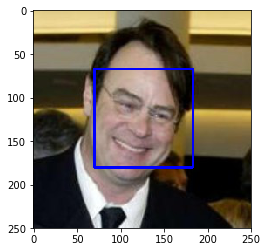

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
logger.info('Number of faces detected: %d', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
- 98.0%
- 17.0%

In [5]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

human_face_detections = [x for x in map(face_detector, human_files_short)]
dog_face_detections = [x for x in map(face_detector, dog_files_short)]

human_count = np.sum(human_face_detections)
dog_count = np.sum(dog_face_detections)

human_perc = human_count * 100 / len(human_files_short)
dog_perc = dog_count * 100 / len(dog_files_short)

logger.info("Human Accuracy: %.2f%% | Dogs Accuracy: %.2f%%", human_perc, dog_perc)

03-20 02:40 dog_breed INFO Human Accuracy: 98.00% | Dogs Accuracy: 17.00%


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [6]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

logger.info("CUDA is enabled" if use_cuda else "CPU Mode")

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:06<00:00, 91859843.04it/s]
03-20 02:41 dog_breed INFO CUDA is enabled


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [7]:
from PIL import Image
import torchvision.transforms as transforms

def VGG16_predict(img_path):
    """
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    """
    
    image = Image.open(img_path)
    
    preprocess = transforms.Compose([
       transforms.Resize(256),
       transforms.CenterCrop(224),
       transforms.ToTensor(),
       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    ])    
    
    image = preprocess(image).unsqueeze_(0)

    if use_cuda: 
        image = image.cuda()

    # Get predicted category for image
    with torch.no_grad():
        output = VGG16(image)
        predicted = output.argmax()
        
    return predicted # predicted class index

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [8]:
MIN_INDEX_DOG = 151
MAX_INDEX_DOG = 268

### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    predicted = VGG16_predict(img_path=img_path)
    return MIN_INDEX_DOG <= predicted <= MAX_INDEX_DOG

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__

- 0%
- 100%

In [9]:
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

human_face_detections = [x for x in map(dog_detector, human_files_short)]
dog_face_detections = [x for x in map(dog_detector, dog_files_short)]

human_count = np.sum(human_face_detections)
dog_count = np.sum(dog_face_detections)

human_perc = human_count * 100 / len(human_files_short)
dog_perc = dog_count * 100 / len(dog_files_short)

logger.info("Human Accuracy: %.2f%% | Dogs Accuracy: %.2f%%", human_perc, dog_perc)

03-20 02:41 dog_breed INFO Human Accuracy: 1.00% | Dogs Accuracy: 99.00%


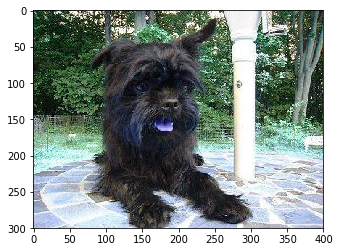

In [10]:
img_path = '/data/dog_images/train/001.Affenpinscher/Affenpinscher_00001.jpg'
img = cv2.imread(img_path)
predicted = VGG16_predict('/data/dog_images/train/001.Affenpinscher/Affenpinscher_00001.jpg')
plt.imshow(img)

We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [11]:
import os
from torchvision import datasets
from torch.utils.data import DataLoader

batch_size = 64
num_workers = 0

transform_train = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

transform_others = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

root_dir = os.path.join("/data/dog_images")

train_loader = DataLoader(
    datasets.ImageFolder(os.path.join(root_dir, "train"), transform=transform_train),
    batch_size=batch_size, shuffle=True, num_workers=num_workers)

validation_loader = DataLoader(
    datasets.ImageFolder(os.path.join(root_dir, "valid"), transform=transform_others),
    batch_size=batch_size, shuffle=True, num_workers=num_workers)

test_loader = DataLoader(
    datasets.ImageFolder(os.path.join(root_dir, "test"), transform=transform_others),
    batch_size=batch_size, shuffle=False, num_workers=num_workers)

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:

- Based ont the state of the art architectures such as VGGNet and AlexNet, I chose to crop the images to 224 x 224 size after resizing them to width of 256.
- I added horizontal flips and random 10 deg rotations to augment the dataset. 

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [12]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()

        # Conv Layers 
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3) 
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.conv4 = nn.Conv2d(64, 128, 3)
        self.conv5 = nn.Conv2d(128, 256, 3)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(5 * 5 * 256, 400)
        self.fc2 = nn.Linear(400, 133)
        
        # Dropout
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        ## Define forward behavior
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x))) 
        x = self.pool(F.relu(self.conv5(x))) 
        
        # Flatten
        x = x.view(-1, 5 * 5 * 256)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

logger.info("\n%s", model_scratch)

03-20 02:41 dog_breed INFO 
Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6400, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=133, bias=True)
  (dropout): Dropout(p=0.3)
)


__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ I decided to take inspiration from AlexNet to train the model. 

I added 5 convolutional layers to learn the features in the images and then added 2 fully connected layers for the classification. Each convolutional layer is also followed by relu activation and a max-pooling layer. I also added a dropout layer after the the 1st fully connected layer to avoid overfitting. 

Finally the output from the second fully connected layer is fed into softmax function to get the probabilities. 

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [13]:
import torch.optim as optim

### select loss function
criterion_scratch = nn.CrossEntropyLoss()

### select optimizer
optimizer_scratch = optim.Adam(model_scratch.parameters())

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [14]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    
    import time
    from tqdm import tqdm
    from PIL import ImageFile
    ImageFile.LOAD_TRUNCATED_IMAGES = True
    
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    batch_count = 1 + (len(loaders['train'].dataset.samples) // 
                       loaders['train'].batch_size)
    
    logger.info("NUM OF BATCHES: %d", batch_count)
    logger.info("NUM OF EPOCHS:  %d", n_epochs)
    logger.info("OPTIMIZER:      %s", optimizer.__class__.__name__)
    logger.info("CRITTERION:     %s", criterion.__class__.__name__)
    logger.info("USING CUDA?:    %s", use_cuda)
    
    for epoch in range(n_epochs):
        logger.info('EPOCH {}'.format(epoch + 1))
        
        start_time = time.time()
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        model.train()
        for batch_idx, (data, target) in tqdm(enumerate(loaders['train']), total=batch_count):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            # clear the gradients    
            optimizer.zero_grad()
            
            # model forward pass
            output = model(data)
            
            # calculate the loss for the batch
            loss = criterion(output, target)
            
            # model backward pass
            loss.backward()
            
            # next optimization step
            optimizer.step()
            
            # update training loss
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.item() - train_loss))

        ######################    
        # validate the model #
        ######################
        
        # set to eval mode
        model.eval() 
        
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to gpu
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            # No Gradient Calculation Required
            with torch.no_grad():
                output = model(data)
            
            # Calculate validation loss
            loss = criterion(output, target)
            
            # update validation loss
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.item() - valid_loss))
            
        logger.debug('Training Loss: {:.6f}\nValidation Loss: {:.6f}'.format(train_loss, valid_loss))
        
        ## save the model if validation loss has decreased
        
        if valid_loss < valid_loss_min:
            logger.info("Validation Loss Decreased: {:.6f} => {:.6f}. Saving Model to {}".format(
                valid_loss_min, valid_loss, save_path))
            
            valid_loss_min = valid_loss
            
            torch.save(model.state_dict(), save_path)
        
        time_taken = time.time() - start_time
        
        logger.info("EPOCH took {}s".format(np.round(time_taken, 2)))
            
    # return trained model
    return model

In [15]:
loaders_scratch = {'train': train_loader, 
                   'valid': validation_loader, 
                   'test': test_loader}

n_epochs = 20

# train the model
model_scratch = train(n_epochs, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

03-20 02:42 dog_breed INFO NUM OF BATCHES: 105
03-20 02:42 dog_breed INFO NUM OF EPOCHS:  20
03-20 02:42 dog_breed INFO OPTIMIZER:      Adam
03-20 02:42 dog_breed INFO CRITTERION:     CrossEntropyLoss
03-20 02:42 dog_breed INFO USING CUDA?:    True
03-20 02:42 dog_breed INFO EPOCH 1
100%|██████████| 105/105 [02:14<00:00,  1.01it/s]
03-20 02:44 dog_breed DEBUG Training Loss: 4.876736
Validation Loss: 4.788141
03-20 02:44 dog_breed INFO Validation Loss Decreased: inf => 4.788141. Saving Model to model_scratch.pt
03-20 02:44 dog_breed INFO EPOCH took 148.82s
03-20 02:44 dog_breed INFO EPOCH 2
100%|██████████| 105/105 [02:01<00:00,  1.03s/it]
03-20 02:46 dog_breed DEBUG Training Loss: 4.682844
Validation Loss: 4.577879
03-20 02:46 dog_breed INFO Validation Loss Decreased: 4.788141 => 4.577879. Saving Model to model_scratch.pt
03-20 02:46 dog_breed INFO EPOCH took 134.88s
03-20 02:46 dog_breed INFO EPOCH 3
100%|██████████| 105/105 [02:00<00:00,  1.05it/s]
03-20 02:49 dog_breed DEBUG Trainin

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [16]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    
    batch_count = 1 + (len(loaders['test'].dataset.samples) // loaders['test'].batch_size)
    
    model.eval()
    for batch_idx, (data, target) in tqdm(enumerate(loaders['test']), total=batch_count):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    logger.info('Test Loss: {:.6f}'.format(test_loss))

    logger.info('Test Accuracy: %2d%% (%2d/%2d)', 100. * correct / total, correct, total)

In [17]:
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

In [18]:
# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

100%|██████████| 14/14 [00:13<00:00,  1.03it/s]
03-20 03:27 dog_breed INFO Test Loss: 3.743666
03-20 03:27 dog_breed INFO Test Accuracy: 16% (142/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [19]:
import os
from torchvision import datasets
from torch.utils.data import DataLoader

batch_size = 64
num_workers = 0

transform_train = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_others = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

root_dir = "/data/dog_images"

train_loader = DataLoader(
    datasets.ImageFolder(os.path.join(root_dir, "train"), transform=transform_train),
    batch_size=batch_size, shuffle=True, num_workers=num_workers)

validation_loader = DataLoader(
    datasets.ImageFolder(os.path.join(root_dir, "valid"), transform=transform_others),
    batch_size=batch_size, shuffle=True, num_workers=num_workers)

test_loader = DataLoader(
    datasets.ImageFolder(os.path.join(root_dir, "test"), transform=transform_others),
    batch_size=batch_size, shuffle=False, num_workers=num_workers)

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [20]:
import torchvision.models as models
import torch.nn as nn

model_transfer = models.vgg16(pretrained=True)

for param in model_transfer.features.parameters():
    param.requires_grad = False

n_inputs = model_transfer.classifier[6].in_features
n_classes = len(train_loader.dataset.classes)

last_layer = nn.Linear(n_inputs, n_classes)
model_transfer.classifier[6] = last_layer

logger.info("\n{}".format(model_transfer))

if use_cuda:
    model_transfer = model_transfer.cuda()

03-20 03:27 dog_breed INFO 
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ As we learned earlier in this project, VGG16 has been trained on a wide array of dog images and has learned high level and complex features that would be really helpful for identifucation of dog breed as well. So, I decided to start with the VGG16 model and fixed the feature extractor part of the model. For the classification part of the model architecture, I replaced the final fully connected layer to output one of 133 categories that we are interested in. After that, I train the classification part of the model i.e. all the fully connected layers to learn dog breed classifications. 

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [21]:
import torch.optim as optim

criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(model_transfer.classifier.parameters())

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [22]:
loaders_transfer = {'train': train_loader, 
                   'valid': validation_loader, 
                   'test': test_loader}

n_epochs = 8

In [23]:
# train the model
model_transfer = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, 
                      criterion_transfer, use_cuda, 'model_transfer.pt')


03-20 03:27 dog_breed INFO NUM OF BATCHES: 105
03-20 03:27 dog_breed INFO NUM OF EPOCHS:  8
03-20 03:27 dog_breed INFO OPTIMIZER:      Adam
03-20 03:27 dog_breed INFO CRITTERION:     CrossEntropyLoss
03-20 03:27 dog_breed INFO USING CUDA?:    True
03-20 03:27 dog_breed INFO EPOCH 1
100%|██████████| 105/105 [03:14<00:00,  1.60s/it]
03-20 03:31 dog_breed DEBUG Training Loss: 2.786937
Validation Loss: 1.250699
03-20 03:31 dog_breed INFO Validation Loss Decreased: inf => 1.250699. Saving Model to model_transfer.pt
03-20 03:31 dog_breed INFO EPOCH took 217.29s
03-20 03:31 dog_breed INFO EPOCH 2
100%|██████████| 105/105 [03:14<00:00,  1.71s/it]
03-20 03:35 dog_breed DEBUG Training Loss: 2.024088
Validation Loss: 1.275773
03-20 03:35 dog_breed INFO EPOCH took 216.52s
03-20 03:35 dog_breed INFO EPOCH 3
100%|██████████| 105/105 [03:13<00:00,  1.56s/it]
03-20 03:38 dog_breed DEBUG Training Loss: 1.984462
Validation Loss: 1.226940
03-20 03:38 dog_breed INFO Validation Loss Decreased: 1.250699 => 

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [24]:
# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

In [25]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

100%|██████████| 14/14 [00:21<00:00,  1.21s/it]
03-20 03:57 dog_breed INFO Test Loss: 1.092665
03-20 03:57 dog_breed INFO Test Accuracy: 69% (578/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [26]:
# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in train_loader.dataset.classes]

final_model = model_transfer

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    
    image = Image.open(img_path)
    
    preprocess = transforms.Compose([
       transforms.Resize(256),
       transforms.CenterCrop(224),
       transforms.ToTensor(),
       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    ])    
    
    image = preprocess(image).unsqueeze_(0)
    
    if use_cuda:
        image = image.cuda()

    with torch.no_grad():
        output = final_model(image)
        prediction = torch.argmax(output).item()
        
    breed = class_names[prediction]
    
    return breed

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [27]:
def run_app(img_path):
    if face_detector(img_path):
        logger.info('Hello Human!')
        plt.imshow(Image.open(img_path))
        plt.show()
        logger.info('You look like a {}'.format(predict_breed_transfer(img_path)))
    elif dog_detector(img_path):
        plt.imshow(Image.open(img_path))
        plt.show()
        logger.info('This is a picture of a {}'.format({predict_breed_transfer(img_path)}))
    else:
        plt.imshow(Image.open(img_path))
        plt.show()
        logger.warning('Sorry, I did not detect a human or a dog in this image.')
    logger.info("------------------------------------------------------")

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ The output was better than what I expected it to be considering that identifying individual breeds of dogs is a hard task for even humans.

To further improve, we can

- Increase the number of convolutional layers to lean even more complex features signifying specific breeds of dogs
- We can increase the number of epochs (but this could also lead to overfitting and we might get diminishing returns on the validation loss)
- We can transfer learn from another start of the art model with higher accuracy such as ResNet

03-20 03:57 dog_breed INFO Hello Human!


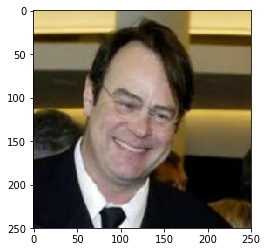

03-20 03:57 dog_breed INFO You look like a Cane corso
03-20 03:57 dog_breed INFO ------------------------------------------------------
03-20 03:57 dog_breed INFO Hello Human!


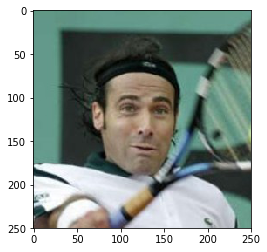

03-20 03:57 dog_breed INFO You look like a Italian greyhound
03-20 03:57 dog_breed INFO ------------------------------------------------------
03-20 03:57 dog_breed INFO Hello Human!


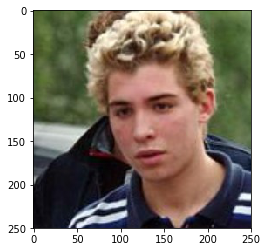

03-20 03:57 dog_breed INFO You look like a Kerry blue terrier
03-20 03:57 dog_breed INFO ------------------------------------------------------


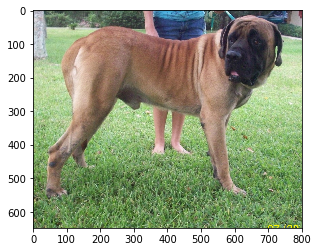

03-20 03:57 dog_breed INFO This is a picture of a {'Bullmastiff'}
03-20 03:57 dog_breed INFO ------------------------------------------------------


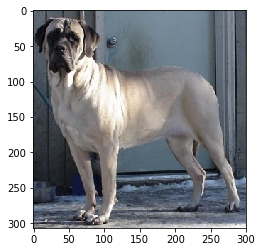

03-20 03:57 dog_breed INFO This is a picture of a {'Neapolitan mastiff'}
03-20 03:57 dog_breed INFO ------------------------------------------------------


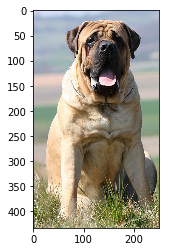

03-20 03:57 dog_breed INFO This is a picture of a {'Bullmastiff'}
03-20 03:57 dog_breed INFO ------------------------------------------------------


In [28]:
## suggested code, below
for file in np.hstack((human_files[:3], dog_files[:3])):
    run_app(file)

03-20 04:02 dog_breed INFO Hello Human!


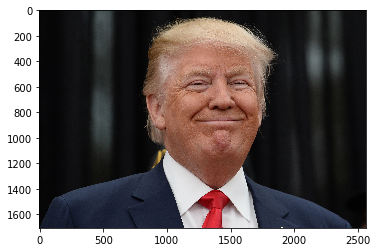

03-20 04:02 dog_breed INFO You look like a Chinese crested
03-20 04:02 dog_breed INFO ------------------------------------------------------


In [29]:
run_app("./images/test1.jpg")

03-20 04:04 dog_breed INFO Hello Human!


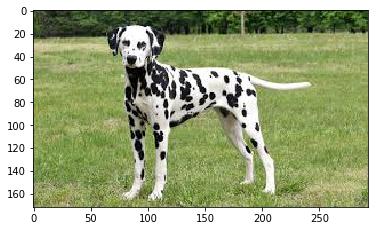

03-20 04:04 dog_breed INFO You look like a Dalmatian
03-20 04:04 dog_breed INFO ------------------------------------------------------


In [30]:
run_app("./images/test2.jpg")

03-20 04:04 dog_breed INFO Hello Human!


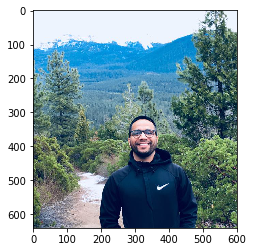

03-20 04:04 dog_breed INFO You look like a Neapolitan mastiff
03-20 04:04 dog_breed INFO ------------------------------------------------------


In [31]:
run_app("./images/test3.jpg")